# Homework 3 (Due Oct. 11)

## 1. The occasionally dishonest casino

Imagine that you are employed by the Montana State Gaming Board, and you have received an anonymous tip suggesting that the dealer in the dice games that frequently occur at the Oxford is cheating.  In particular, the dealer is surreptitiously switching from a fair die to a loaded one (and back) with a certain probability.  In this game, the ante is a doller.  you choose a number, the dealer rolls the die, and if it matches you get back 3 times your ante.  Otherwise, you lose your ante.  

You examine security camera footage from which you extracted the following dataset, with *states* describing whether the die was loaded, and rolls being the outcome of each die roll.

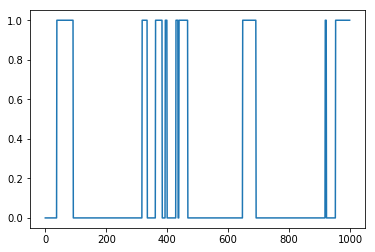

In [3]:
import pickle
import matplotlib.pyplot as plt

states,rolls = pickle.load(open('oxford.p','rb'))
plt.plot(states)
plt.show()

### 1a. Training a HMM (20pts)
Assume that the dealer follows a Markov model
$$
P(S_{t+1}=s_k|S_t=s_j) = A_{jk}, s_j\in\{0,1\},s_k\in\{0,1\},
$$
where $s_j=0$ corresponds to use of the fair die, while $s_j=1$ means the die is loaded.  The outcome of the die roll follows a categorical distribution conditioned on which die was being used
$$
P(R_t=r|S_t=s_j) = E_{jr}, r_t\in\{0,1,2,3,4,5\}.
$$
Note that for convenience, the dealer is using a six-sided, zero-indexed die.

Train your model of the dealer's ruse by using your observations to find the maximum likelihood estimators for the transition matrix $A$ and the emission probabilities $E$.  

HINT: because the states are observed, training $A$ is equivalent to training a normal Markov model.  Similarly, training $E$ is equivalant to training a Naive Bayes model, where the state is the class and the die roll is the feature.

In [4]:
import numpy as np
m = len(states)

A = np.zeros((2,2))
E = np.zeros((2,6))

#! Compute the parameters of the transition and emission matrices.

# Separate the first emission data (since it doesn't have a transition)
E[states[0]][rolls[0]] += 1

# Count the parameters using the data
for i in range(1, m):
    A[states[i-1]][states[i]] += 1 # Count transitions from a state to next state
    E[states[i]][rolls[i]] += 1    # Count emissions of rolls for each state

# Check the raw frequency counts
print('Frequency count for transitions:\n', A, '\n\nFrequency count for emissions:\n', E, '\n\n')

# Modifying transition frequency counts to probabilities
num_rows, num_cols = A.shape
freq = A.copy() # To avoid modifying data while being read
for i in range(num_rows):
    for j in range(num_cols):
        A[i][j] /= np.sum(freq[i])
        
# Modifying emission frequency counts to probabilities
num_rows, num_cols = E.shape
freq = E.copy()
for i in range(num_rows):
    for j in range(num_cols):
        E[i][j] /= np.sum(freq[i])

# Check the probabilities calculated
print('Probabilities for transitions:\n', A, '\n\nProbabilities for emissions:\n', E)

Frequency count for transitions:
 [[761.   9.]
 [  8. 221.]] 

Frequency count for emissions:
 [[128. 137. 109. 130. 144. 122.]
 [ 19.  15.  29.  21.  26. 120.]] 


Probabilities for transitions:
 [[0.98831169 0.01168831]
 [0.0349345  0.9650655 ]] 

Probabilities for emissions:
 [[0.16623377 0.17792208 0.14155844 0.16883117 0.18701299 0.15844156]
 [0.0826087  0.06521739 0.12608696 0.09130435 0.11304348 0.52173913]]


### 1b. Determining when the house is cheating. (20pts)
Now that you know the cheating dealer's strategy, you decide that you want to catch the dealer in the act.  Play 1000 games of dice with the dealer, using the forward algorithm to determine when the dealer is cheating.  Recall that you now don't have access to the dealer's state, only the rolls!  Assume that the dealer starts using the fair die.  Report the probability that the dealer is using the loaded die at each of the 1000 rolls.

HINT: In the notation of Murphy, you are looking for $P(z_t=j|\mathbf{x}_{1:t})=\alpha_t(j)$, where $z_t=j\in\{0,1\}$ are the possible states and $\mathbf{x}_{1:t}$ are all the die rolls up to the current time.  The two step formula for computing this quantity can be found in Murphy Eqs. 17.44-17.47.


In [5]:
def likelihood(roll,state):
    return E[state,roll]

def prediction(state):
    return np.dot(state,A)

possible_states = [0,1]
possible_rolls = [0,1,2,3,4,5]

def simulation():
    #alpha = [np.array([1.0,0.0])]
    alpha = np.array([1.0, 0.0])
    current_state = 0
    current_roll = np.random.choice(possible_rolls,p=E[0])

    states = [current_state]
    rolls = [current_roll]

    guesses = [current_state]

    for g in range(1000):

        ### This is the dealer's internal state, you can't use this information!
        current_state = np.random.choice(possible_states,p=A[current_state])
        states.append(current_state)
        ###

        ### This is the dealer's emission, you *can* use this information
        current_roll = np.random.choice(possible_rolls,p=E[current_state])
        rolls.append(current_roll)
        ###

        #! Implement the recursive forward algorithm to determine the probability 
        #! of being in the fair or loaded state for all rolls
        prev_alpha = alpha.copy()
        for i in range(len(possible_states)):
            # Start with the emission probability of the observed in a state
            alpha[i] = E[i][current_roll]           
            prev_sum = 0
            # Sum up all possibilities of arriving to this state
            # e.g. the probability of being in a state previously and then 
            # transitioning to this new state
            for j in range(len(possible_states)):
                 prev_sum += A[i][j] * prev_alpha[j]
            # Factor the emission probability together with the probability of
            # arriving to this state now
            alpha[i] *= prev_sum

        # Normalize alpha to get probability distribution
        alpha_tot = sum(alpha)
        for i in range(len(possible_states)):
            alpha[i] /= alpha_tot

        # This is to just check the accuracy of the model.
        if alpha[1] > alpha[0]:
            guesses.append(1)
        elif alpha[0] > alpha[1]:
            guesses.append(0)

        # This is only commented out to use this whole simulation as a function without re-printing
        #print('P(loaded):', alpha[1])
        
    return states, rolls, guesses

states, rolls, guesses = simulation()

In [6]:
correct = sum([guesses[i] == states[i] for i in range(len(guesses))])

print('\nAccuracy:', str(round(correct/len(guesses) * 100, 2)) + '%')


Accuracy: 89.51%


### 1C (\*). Beating the house (10pts)
Describe a strategy for beating the house given all the information determined from the above two problems.  Show that your strategy will, in general, make money after 1000 rolls, either by mathematical proof, or by direct simulation. 

$\textbf{Answer}$

We can use the model we developed above to predict when it is more likely that the previous game was conducted using a loaded or fair die, then we can bet the next game will be conducted without switching. We do this since we know it is much more likely for the casino to keep using its current die from the transition matrix. We then make our bet on the individual result dependent on the emission probabilities for that die's state (e.g. '6' if we think the die is currently loaded and '5' if we think the die is currently 'fair').

Sim: 0
Sim: 100
Sim: 200
Sim: 300
Sim: 400
Sim: 500
Sim: 600
Sim: 700
Sim: 800
Sim: 900


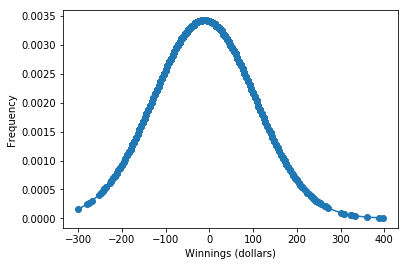

Mean: -11.672 std: 116.5


In [9]:
import numpy as np
import scipy.stats as stats

winnings = []

for s in range(1000):
    states, rolls, guesses = simulation()
    money = 0

    # On the first roll we just assume the die is fair so we guess '5'
    if (rolls[0] == 4):
        money += 3
    else:
        money -= 1

    # For the next 999 games...
    for g in range(1,1000):

        # If the model thinks the last state was a fair die,
        # assume we're still on a fair die and guess the most
        # likely outcome from our training (e.g.'5').
        if (guesses[g-1] == 0 and rolls[g] == 4):
            money += 3
        elif (guesses[g-1] == 0 and rolls[g] != 4):
            money -= 1

        # Otherwise, if the model thinks the last state was loaded,
        # assume we're still on a loaded die and guess the most
        # likely outcome from our training (e.g.'6')
        elif (guesses[g-1] == 1 and rolls[g] == 5):
            money += 3
        else:
            money -= 1
    
    winnings.append(money)
    if (s % 100 == 0):
        print('Sim:', s)

winnings = sorted(winnings)

fit = stats.norm.pdf(winnings, np.mean(winnings), np.std(winnings))

plt.plot(winnings,fit,'-o')
plt.xlabel("Winnings (dollars)")
plt.ylabel("Frequency")

plt.show()

print("Mean:", np.mean(winnings), "std:", str(round(np.std(winnings),2)))

$\textbf{Answer}$

Alternatively, it looks like the factor of guessing 5 (under the assumption we'll stay on the fair die) when we're actually switching may be negatively impacting this strategy too much. That is to say that the probability of rolling 5 on these transition rolls may not outweigh the "benefit" we get with the slightly increased odds over 1/6 we saw in the training phase. An alternative strategy to fix this would be the simple method of betting 6 $\textit{all}$ the time.

Sim: 0
Sim: 100
Sim: 200
Sim: 300
Sim: 400
Sim: 500
Sim: 600
Sim: 700
Sim: 800
Sim: 900


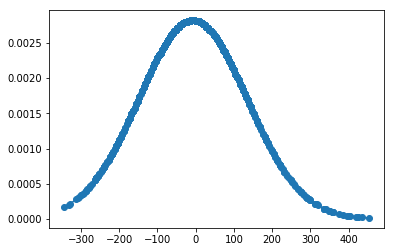

Mean: -7.828 std: 141.39


In [8]:
import numpy as np
import scipy.stats as stats

winnings = []

for s in range(1000):
    states, rolls, guesses = simulation()
    money = 0

    for g in range(1000):
        if rolls[g] == 5:
            money += 3
        else:
            money -= 1
    
    winnings.append(money)
    if (s % 100 == 0):
        print('Sim:', s)

winnings = sorted(winnings)

fit = stats.norm.pdf(winnings, np.mean(winnings), np.std(winnings))

plt.plot(winnings,fit,'-o')
plt.xlabel("Winnings (dollars)")
plt.ylabel("Frequency")

plt.show()

print("Mean:", np.mean(winnings), "std:", str(round(np.std(winnings),2)))

$\textbf{Answer}$

The expected value of this game is:
$$ W = (P(r=6|z_t=0) P(z_t=0|z_{t-1}=0) + P(r=6|z_t=1) P(z_t=1|z_{t-1}=1)) + P(r=6|z_t=1) P(z_t=1|z_{t-1}=0) + P(r=6|z_t=0) P(z_t=0|z_{t-1}=1)$$

$$W = 1/6 * 0.9883 +  0.5217 * 0.9651 +  0.5217 * 0.0117 + 1/6 * 0.0349$$
$$\approx 0.6801$$

$$3W - (1-W) $$
$$\approx \$1.7204 $$

So one could expected to win with this strategy in the long run if the die isn't overtly staying on a run of being fair since the expected value while being fairly is negative: $3*1/6 - 5/6 = -1/3$.

## 2. The Kalman Filter

### 2a.  Tracking in 2D.  (30pts)
Imagine that we are monitoring the position of an aircraft, moving according to a so-called *constant velocity* model, in which:
$$
x_{t+1} = x_t + \Delta t u_t + \frac{\Delta t^2}{2} a_x^2
$$
$$
y_{t+1} = y_t + \Delta t v_t + \frac{\Delta t^2}{2} a_y^2
$$
$$
u_{t+1} = u_t + \Delta t a_x
$$
$$
v_{t+1} = v_t + \Delta t a_y,
$$
where $x$ and $y$ are the spatial coordinates in the map-plane (measured in km), $u$ and $v$ are the corresponding velocities measured in (km/s), and $a_x$ and $a_y$ are random accelerations due to buffeting by winds that are independent from one another.  $\Delta t=0.1 \mathrm{s}$ is the measurement interval, and the time step involved in computing the evolution of the aircraft state.   

Defining $\mathbf{z}_t=[x_t,u_t,y_t,v_t]$, we can write this model as
$$
\mathbf{z}_{t+1} = \mathbf{A}_t \mathbf{z}_t + \mathbf{\epsilon}_t,
$$
where $A$ is a *state transition matrix* given by
$$
\mathbf{A}_t = \begin{bmatrix} 1 & \Delta t & 0 & 0 \\
                    0 & 1 & 0 & 0  \\
                    0 & 0 & 1 & \Delta t \\
                    0 & 0 & 0 & 1 \end{bmatrix}.
$$

We assume that $\mathbf{\epsilon}_t = [\frac{\Delta t^2}{2} a_x^2, \Delta t a_x, \frac{\Delta t^2}{2} a_y^2, \Delta t a_y] \sim \mathcal{N}(0,\mathbf{Q}_t)$ is Gaussian noise with a zero mean, and $\mathbf{Q}_t$ is the covariance matrix
$$
\mathbf{Q}_t = a^2 \begin{bmatrix} 1/4 \Delta t^4 & 1/2\Delta t^3 & 0 &         0 \\
                        1/2 \Delta t^3 & \Delta t^2    & 0 &         0 \\
                        0 & 0 & 1/4 \Delta t^4 & 1/2\Delta t^3 \\
                        0 & 0 & 1/2 \Delta t^3 & \Delta t^2    \end{bmatrix},
$$
where $a=0.1 \mathrm{km/s}^2$ is a characteristic acceleration due to buffeting winds.

A global positioning unit fixed to the hull measures the coordinates $x$ and $y$.  At a fixed interval $\Delta t$ the unit returns an observation $\mathbf{y}_t = \mathbf{C}_t \mathbf{z}_t + \mathbf{\delta}_t$, where
$$
\mathbf{C}_t = \begin{bmatrix} 1 & 0 & 0 & 0 \\
                    0 & 0 & 1 & 0 \end{bmatrix}
$$
is the observation matrix, mapping the state variables to observations (essentially picking out the positions and ignoring the velocities since these are not directly measured) and $\mathbf{\delta}_t \sim \mathcal{N}(0,\mathbf{R}_t)$ is Gaussian observation noise with $\mathbf{R}_t$ the observation covariance
$$
R_t = \begin{bmatrix} 0.05^2 & 0 \\
                           0 & 0.05^2 \end{bmatrix},
$$
indicating that positions are observed with a standard deviation of 0.05 km.

We seek the posterior probability distribution of states $P(\mathbf{z}_t|\mathbf{y}_{1:t}) = \mathcal{N}(\mu_t,\Sigma_t)$ having made measurements up to and including the current time.  This distribution combines our knowledge of the aircraft motion with our observations, both of which are imperfect due to randomness in the physical process (random winds) and in the observation process (measurement error).  The Kalman filter provides a recursive formula to find the distribution mean $\mu_t$ and covariance $\Sigma_t$.

Apply the Kalman filter to the aircraft motion and resulting observations simulated below.  After applying the filter, **generate a plot of the true aircraft positions, the observations, and the position estimates generated by filtering**.  **Report both the final and initial covariance matrices, and describe whether our state estimates are becoming more or less certain as filtering proceeds.**

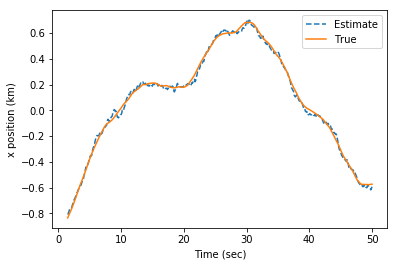

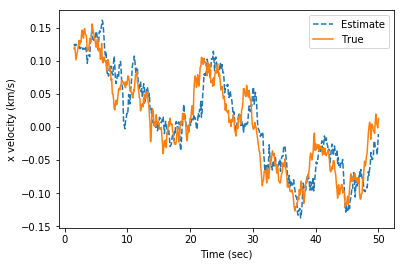

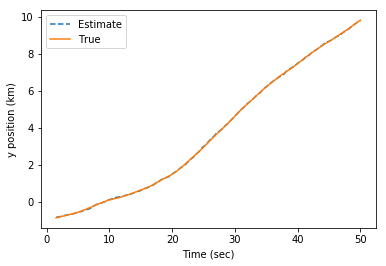

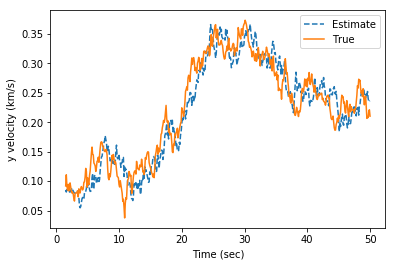

Initial Covariance Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

Fifteenth Covariance Matrix:
 [[ 0.00084143  0.00049418  0.          0.        ]
 [ 0.00049418 -0.0009187   0.          0.        ]
 [ 0.          0.          0.00084143  0.00049418]
 [ 0.          0.          0.00049418 -0.0009187 ]] 

Final Covariance Matrix:
 [[0.00043916 0.00044301 0.         0.        ]
 [0.00044301 0.00094131 0.         0.        ]
 [0.         0.         0.00043916 0.00044301]
 [0.         0.         0.00044301 0.00094131]]


In [360]:
import numpy as np

# Constants
a = 0.1   # Acceleration due to wind
dt = 0.1  # Interval for measurements

# Transition matrix
A = np.array([[1.0,dt,0.0,0.0],
              [0.0,1.0,0.0,0],
              [0.0,0.0,1.0,dt],
              [0.0,0.0,0,1.0]])

# Process noise covariance
Q = a**2*np.array([[1/4.*dt**4,1/2.*dt**3,         0,         0],
                   [1/2.*dt**3,     dt**2,         0,         0],
                   [         0,         0,1/4.*dt**4,1/2.*dt**3],
                   [         0,         0,1/2.*dt**3,     dt**2]])

Q += 1e-5*np.sum(np.diag(Q))*np.eye(4)

# Observation matrix
C = np.array([[1,0,0,0],
              [0,0,1,0]])

# Observation covariance
R = np.array([[0.05**2,0],
              [0,0.05**2]])

### These are useful for sampling from normal distributions, but you
### don't need to worry about them.  
Q_cholesky = np.linalg.cholesky(Q)
R_cholesky = np.linalg.cholesky(R)
###
###


### The true state of the aircraft
### You do not have access to this information!
###
Z_true = [np.array([-1,0.1,-1,0.1])]
###
###
###

# Initial guess for aircraft position and velocity
mu_initial = np.array([0,0,0,0])

# Covariance matrix for this initial guess of position and velocity 
Sigma_initial = np.eye(4)*np.diag(np.array([1,1,1,1]))

# Lists for holding estimated states
mu = [mu_initial]
Sigma = [Sigma_initial]
Y = []


t=0
t_end = 50
while t<t_end:
    
    ### Simulate the motion of the aircraft
    ### You do not have access to this information!
    ### Don't change!
    Z_0 = Z_true[-1]                                            
    Z_1 = np.dot(A,Z_0) + np.dot(Q_cholesky,np.random.randn(4))  # Move the plane forward in time
    Z_true.append(Z_1)
    Y_1 = np.dot(C,Z_1) + np.dot(R_cholesky,np.random.randn(2))  # Take a noisy measurement
    Y.append(Y_1)
    ###
    ###
    ###
    
    mu_previous = mu[-1] # Best state mean estimate from last time step
    Sigma_previous = Sigma[-1] # state covariance from last time step
    Y_current = Y[-1]  # Current observation
    
    # Prediction step
    #! Write code to predict
    
    #! a) where the airplane will be according to the motion model
    mu_prior = np.dot(A, mu_previous) 
    #! b) the covariance of that estimate
    Sigma_prior = np.dot(np.dot(A,Sigma_previous), A.T) + Q
   
    # Update step
    #! Implement the formulae for the update step of the Kalman filter
    innov_cov = R + np.dot(np.dot(C,Sigma_previous), C.T)              #  Innovation covariance
    k_gain = np.dot(np.dot(Sigma_prior,C.T), np.linalg.inv(innov_cov)) #  Optimal Kalman gain
    mu_post = mu_prior + np.dot(k_gain,Y_current-np.dot(C,mu_prior))   #! The posterior state mean estimate 
    Sigma_post = np.dot(np.eye(4) - np.dot(k_gain,C), Sigma_prior)     #! The posterior covariance estimate
    
    mu.append(mu_post)
    Sigma.append(Sigma_post)
    
    t+=dt
    
#! Plotting goes here.
# Convert the array of np arrays
mu = np.array(mu)
Z_true = np.array(Z_true)

x_s = np.linspace(0,t_end,len(mu))
ylabels = ("x position (km)", "x velocity (km/s)", "y position (km)", "y velocity (km/s)")

# Go through all four values that are being estimated in z.
# Note that we start 15 steps into the process so that the scaling
# from the bad estimates in the early stages doesn't overwhelm the plot.
for i in range(4):
    plt.plot(x_s[15:], mu[15:,i], linestyle='dashed', label="Estimate")
    plt.plot(x_s[15:], Z_true[15:,i], label="True")
    plt.ylabel(ylabels[i])
    plt.xlabel("Time (sec)")
    plt.legend()
    plt.show()
    
print('Initial Covariance Matrix:\n', Sigma[0], '\n')
print('Fifteenth Covariance Matrix:\n', Sigma[16], '\n')
print('Final Covariance Matrix:\n', Sigma[-1])

$\textbf{Answer}$

As we can see from the diagonals of our covariance matrix, we have gained much $\textbf{more}$ confidence in our measurements.  The magnitude of the elements in the covariance matrix have decreased over time. Notably, we have additional variance factored in concerning x position to x velocity and y position to y velocity (compared to naive initial matrix that assumes none in these positions). However, as we can see from a comparison of the fifteenth and final covariance matrices even this uncertainty value is decreasing.

### 2b (\*) Extended Kalman Filter. (20pts)
The Kalman filter only applies to observation models that are linear.  However, this is a restrictive assumption.  Consider the case where instead of tracking the plane with a GPS, we are tracking it with a radar, where the radar provides an estimate of range ($\rho_t$) and angle ($\theta_t$).  Assuming that the radar is located at $(x=0,y=0)$, the process of taking an observation then is:
$$
\mathbf{y}_t = h(\mathbf{z}_t) + \mathbf{g}_t
$$
where $h(\mathbf{z}_t)$ is the transformation from Cartesian to Polar coordinates
$$ h(\mathbf{z}_t) = \left[ \rho_t(\mathbf{z}_t), \theta_t(\mathbf{z_t})\right] = \left[\sqrt{x_t^2 + y_t^2},\mathrm{arctan2}(y_t,x_t)\right]. $$

An extended Kalman filter works by linearizing the observation process, which is to say that every time we see the product $\mathbf{C}_t\mathbf{z_t}$ in the Kalman filter algorithm, we replace it with $h(\mathbf{z_t})$, and every time we see $\mathbf{C}_t$ on its own, we replace it with the **Jacobian matrix** $H_{jac}(\mathbf{z}_t)$, which is given by
$$
H_{jac}(\mathbf{z}_t) = \begin{bmatrix} \frac{\partial \rho_t}{\partial x_t} & \frac{\partial \rho_t}{\partial u_t} & \frac{\partial \rho_t}{\partial y_t} & \frac{\partial \rho_t}{\partial v_t} \\
                          \frac{\partial \theta_t}{\partial x_t} & \frac{\partial \theta_t}{\partial u_t} & \frac{\partial \theta_t}{\partial y_t} & \frac{\partial \theta_t}{\partial v_t}
                          \end{bmatrix}
$$
Compute this Jacobian matrix and alter your Kalman Filter code to **implement the Extended Kalman Filter. Produce the same plots as in the previous section.**

Note that the code skeleton produces observations that are now in terms of $\rho_t$ and $\theta_t$ and the observational covariance $\mathbf{R}$ has been altered to account for the different magnitude of errors in these values.  Also note that **the complete EKF equations are given (in somewhat altered notation) in Murphy Eqs. 18.85-18.92.**



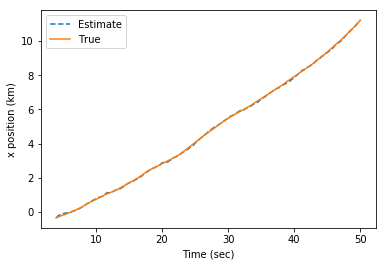

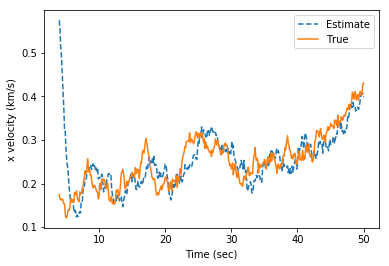

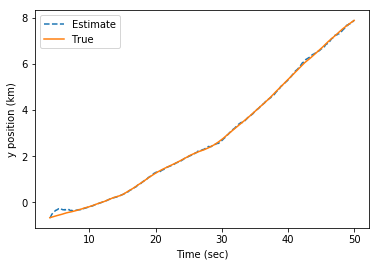

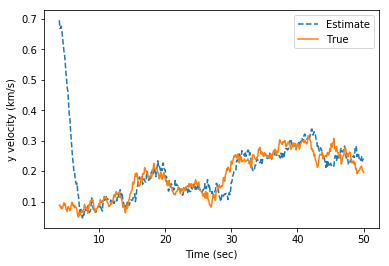

Initial Covariance Matrix:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]] 

Fifteenth Covariance Matrix:
 [[-0.01103548 -0.00766044  0.01231938  0.00859026]
 [-0.00766044 -0.00590396  0.00865498  0.00710161]
 [ 0.01231938  0.00865498 -0.00965667 -0.00675086]
 [ 0.00859026  0.00710161 -0.00675086 -0.00528647]] 

Final Covariance Matrix:
 [[ 0.00154717  0.00103435 -0.00035264 -0.00015945]
 [ 0.00103435  0.00143042 -0.00015928 -0.00010267]
 [-0.00035264 -0.00015928  0.00179828  0.00114847]
 [-0.00015945 -0.00010267  0.00114847  0.00150369]]


In [366]:
import numpy as np

# Constants
a = 0.1   # Acceleration due to wind
dt = 0.1  # Interval for measurements

# Transition matrix
A = np.array([[1.0,dt,0.0,0.0],
              [0.0,1.0,0.0,0],
              [0.0,0.0,1.0,dt],
              [0.0,0.0,0,1.0]])

# Process noise covariance
Q = a**2*np.array([[1/4.*dt**4,1/2.*dt**3,         0,         0],
                   [1/2.*dt**3,     dt**2,         0,         0],
                   [         0,         0,1/4.*dt**4,1/2.*dt**3],
                   [         0,         0,1/2.*dt**3,     dt**2]])


# Observation covariance
R = np.array([[0.1**2,0],
              [0,0.01**2]])

# Observation function
def h(X):
    R = np.sqrt(X[0]**2 + X[2]**2)
    theta = np.arctan2(X[2],X[0])
    return np.array([R,theta])

# Jacobian of observation function
def H_jac(X):
    #! Generate a function which returns the Jacobian of h
    H_jac = np.zeros([2,4])
    x = X[0]
    y = X[2]
    
    H_jac[0,0] = (x**2 + y**2)**-0.5 * x  # dp/dx
    H_jac[0,1] = 0                        # dp/du
    H_jac[0,2] = (x**2 + y**2)**-0.5 * y  # dp/dy
    H_jac[0,3] = 0                        # dp/dv
    
    H_jac[1,0] = -y / (x**2 + y**2)       # d0/dx
    H_jac[1,1] = 0                        # d0/du
    H_jac[1,2] = x / (x**2 + y**2)        # d0/dy
    H_jac[1,3] = 0                        # d0/dv
    
    return H_jac

### These are useful for sampling from normal distributions, but you
### don't need to worry about them.  
Q_cholesky = np.linalg.cholesky(Q)
R_cholesky = np.linalg.cholesky(R)

### The true state of the aircraft
### You do not have access to this information!
###
Z_true = [np.array([-1,0.1,-1,0.1])]
###
###
###

# Initial guess for aircraft position and velocity
mu_initial = np.array([-1.0,0.1,-1.0,0.1])

# Covariance matrix for this initial guess of position and velocity 
Sigma_initial = np.eye(4)*1#np.diag(np.array([1,1,1,1]))

# Lists for holding estimated states
mu = [mu_initial]
Sigma = [Sigma_initial]
Y = []

t=0
t_end = 50.0
while t<t_end:
    
    ### Simulate the motion of the aircraft
    ### You do not have access to this information!
    ### Don't change!
    Z_0 = Z_true[-1]                                            
    Z_1 = np.dot(A,Z_0) + np.dot(Q_cholesky,np.random.randn(4))  # Move the plane forward in time
    Z_true.append(Z_1)
    Y_1 = h(Z_1) + np.dot(R_cholesky,np.random.randn(2))  # Take a noisy measurement
    Y.append(Y_1)
    ###
    ###
    ###
    
    mu_previous = mu[-1] # Best state estimate from last time step
    Sigma_previous = Sigma[-1] # state covariance from last time step
    Y_current = Y[-1]  # Current observation
    
    # H = H_jac(X_previous)
    H = H_jac(mu_previous)
    
    # Prediction step
    #! Write code to predict
    
    #! a) where the airplane will be according to the motion model
    mu_prior = np.dot(A, mu_previous) 
    #! b) the covariance of that estimate
    Sigma_prior = np.dot(np.dot(A, Sigma_previous), A.T) + Q
   
    # Update step
    #! Implement the formulae for the update step of the Kalman filter
    innov_cov = R + np.dot(np.dot(H,Sigma_previous), H.T)                 #  Innovation covariance
    k_gain = np.dot(np.dot(Sigma_prior,H.T), np.linalg.inv(innov_cov))    #  Optimal Kalman gain
    mu_post = mu_prior + np.dot(k_gain, Y_current - h(mu_prior))          #! The posterior state mean estimate 
    Sigma_post = np.dot(np.eye(4) - np.dot(k_gain,H), Sigma_prior)        #! The posterior covariance estimate
      
    mu.append(mu_post)
    Sigma.append(Sigma_post)
    
    t+=dt

#! Plotting goes here.
# Convert the array of np arrays
mu = np.array(mu)
Z_true = np.array(Z_true)

x_s = np.linspace(0,t_end,len(mu))
ylabels = ("x position (km)", "x velocity (km/s)", "y position (km)", "y velocity (km/s)")

# Go through all four values that are being estimated in z.
# Note that we start 40 steps into the process so that the scaling
# from the bad estimates in the early stages doesn't overwhelm the plot.
skip = 40
for i in range(4):
    plt.plot(x_s[skip:], mu[skip:,i], linestyle='dashed', label="Estimate")
    plt.plot(x_s[skip:], Z_true[skip:,i], label="True")
    plt.ylabel(ylabels[i])
    plt.xlabel("Time (sec)")
    plt.legend()
    plt.show()
    
print('Initial Covariance Matrix:\n', Sigma[0], '\n')
print('Fifteenth Covariance Matrix:\n', Sigma[16], '\n')
print('Final Covariance Matrix:\n', Sigma[-1])

$\textbf{Answer}$

The process has a similar story to above, but with more non-zero terms in the covariance matrix corresponding to the additional noise associated with nonlinear data. These terms' magnitudes also tend to get smaller as the process continues. However, notice that it takes much longer for the covariance matrix to "dial in" to the accuracy that would be desired (here I skipped the first 40 iterations of the predict/update loop in the graphs compared to the 15 I skipped previously).